# 🚨 Hate Speech Detection Model Training

**Complete Pipeline:** Data Loading → Preprocessing → Feature Engineering → Model Comparison → Selection → Optimization → Saving


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve,
    precision_recall_curve, average_precision_score
)
import pickle
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")


✅ All libraries imported successfully!


In [2]:
# Load the dataset
df = pd.read_csv('../data/dataset.csv')
print(f"Dataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
df.head()


Dataset shape: (24783, 6)
Columns: ['count', 'hate_speech_count', 'offensive_language_count', 'neither_count', 'class', 'tweet']


,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [3]:
# Data Preprocessing & Binary Classification
print("=" * 80)
print("📊 DATA PREPROCESSING & BINARY CLASSIFICATION")
print("=" * 80)

# Explore class distribution
print("\n📈 Class Distribution:")
print(df['class'].value_counts())

# Check for any missing values or unexpected class names
print(f"\n🔍 Unique class values:")
print(df['class'].unique())

# Create binary classification based on numeric labels
# Based on the dataset description: 0=neither, 1=hate_speech, 2=offensive_language
# We want: 1 for hate/offensive (classes 1,2), 0 for neither (class 0)
df['binary_class'] = df['class'].map({0: 1, 1: 1, 2: 0})

# Check for NaN values after mapping
print(f"\n❌ NaN values in binary_class: {df['binary_class'].isna().sum()}")

# Handle any NaN values by dropping them
if df['binary_class'].isna().sum() > 0:
    print("🧹 Dropping rows with NaN values...")
    df = df.dropna(subset=['binary_class'])
    print(f"✅ Dataset shape after cleaning: {df.shape}")

print("\n🎯 Binary Classification:")
print(df['binary_class'].value_counts())
print(f"\nFoul tweets: {df['binary_class'].sum()}")
print(f"Proper tweets: {(df['binary_class'] == 0).sum()}")
print(f"Balance ratio: {df['binary_class'].mean():.3f}")

# Final verification
print(f"\n✅ Final check - NaN values: {df['binary_class'].isnull().sum()}")


📊 DATA PREPROCESSING & BINARY CLASSIFICATION

📈 Class Distribution:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64

🔍 Unique class values:
[2 1 0]

❌ NaN values in binary_class: 0

🎯 Binary Classification:
binary_class
1    20620
0     4163
Name: count, dtype: int64

Foul tweets: 20620
Proper tweets: 4163
Balance ratio: 0.832

✅ Final check - NaN values: 0


In [4]:
# Sample Examples
print("=" * 80)
print("📝 SAMPLE EXAMPLES")
print("=" * 80)

# Check if we have data after cleaning
print(f"📊 Dataset shape after cleaning: {df.shape}")
print(f"📊 Binary class distribution:")
print(df['binary_class'].value_counts())

# Sample foul tweets
foul_samples = df[df['binary_class'] == 1]['tweet'].head(3)
print(f"\n🚨 Foul Tweets (found {len(foul_samples)}):")
if len(foul_samples) > 0:
    for i, tweet in enumerate(foul_samples, 1):
        print(f"{i}. {tweet}")
else:
    print("   No foul tweets found!")

# Sample proper tweets
proper_samples = df[df['binary_class'] == 0]['tweet'].head(3)
print(f"\n✅ Proper Tweets (found {len(proper_samples)}):")
if len(proper_samples) > 0:
    for i, tweet in enumerate(proper_samples, 1):
        print(f"{i}. {tweet}")
else:
    print("   No proper tweets found!")

# Show some raw class examples if binary_class is empty
if df['binary_class'].isna().all() or len(df[df['binary_class'] == 1]) == 0:
    print(f"\n🔍 Raw class examples:")
    print(df['class'].value_counts().head())
    print(f"\nSample tweets by original class:")
    for class_name in df['class'].unique()[:3]:
        sample = df[df['class'] == class_name]['tweet'].head(1)
        if len(sample) > 0:
            print(f"{class_name}: {sample.iloc[0]}")


📝 SAMPLE EXAMPLES
📊 Dataset shape after cleaning: (24783, 7)
📊 Binary class distribution:
binary_class
1    20620
0     4163
Name: count, dtype: int64

🚨 Foul Tweets (found 3):
1. !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
2. !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
3. !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny

✅ Proper Tweets (found 3):
1. !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
2. " momma said no pussy cats inside my doghouse "
3. "@Addicted2Guys: -SimplyAddictedToGuys http://t.co/1jL4hi8ZMF" woof woof hot scally lad


In [5]:
# Train/Test Split
print("=" * 80)
print("🔄 TRAIN/TEST SPLIT")
print("=" * 80)

# Prepare data
X = df['tweet']
y = df['binary_class']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
print(f"Training balance: {y_train.mean():.3f}")
print(f"Test balance: {y_test.mean():.3f}")


🔄 TRAIN/TEST SPLIT
Training set size: 19826
Test set size: 4957
Training balance: 0.832
Test balance: 0.832


## 🔧 Feature Extraction


In [6]:
# Feature extraction with different configurations
vectorizers = {
    'bow_unigrams': CountVectorizer(
        lowercase=True,
        stop_words='english',
        ngram_range=(1, 1),
        max_features=10000
    ),
    'bow_bigrams': CountVectorizer(
        lowercase=True,
        stop_words='english',
        ngram_range=(1, 2),
        max_features=10000
    ),
    'tfidf_unigrams': TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        ngram_range=(1, 1),
        max_features=10000
    ),
    'tfidf_bigrams': TfidfVectorizer(
        lowercase=True,
        stop_words='english',
        ngram_range=(1, 2),
        max_features=10000
    )
}

# Test different vectorizers
results = {}

for name, vectorizer in vectorizers.items():
    print(f"\n=== {name.upper()} ===")
    
    # Fit and transform
    X_train_vec = vectorizer.fit_transform(X_train)
    X_test_vec = vectorizer.transform(X_test)
    
    print(f"Feature matrix shape: {X_train_vec.shape}")
    
    # Test with Logistic Regression
    lr = LogisticRegression(random_state=42, max_iter=1000)
    lr.fit(X_train_vec, y_train)
    y_pred = lr.predict(X_test_vec)
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"Logistic Regression - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")
    
    results[name] = {
        'vectorizer': vectorizer,
        'X_train': X_train_vec,
        'X_test': X_test_vec,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Select best vectorizer (TF-IDF with bigrams)
best_vectorizer_name = 'tfidf_bigrams'
best_vectorizer = results[best_vectorizer_name]['vectorizer']
X_train_best = results[best_vectorizer_name]['X_train']
X_test_best = results[best_vectorizer_name]['X_test']

print(f"\n🏆 SELECTED VECTORIZER: {best_vectorizer_name}")
print(f"   F1-Score: {results[best_vectorizer_name]['f1']:.4f}")
print(f"   Accuracy: {results[best_vectorizer_name]['accuracy']:.4f}")



=== BOW_UNIGRAMS ===
Feature matrix shape: (19826, 10000)
Logistic Regression - Accuracy: 0.9595, Precision: 0.9778, Recall: 0.9733, F1: 0.9756

=== BOW_BIGRAMS ===
Feature matrix shape: (19826, 10000)
Logistic Regression - Accuracy: 0.9617, Precision: 0.9805, Recall: 0.9733, F1: 0.9769

=== TFIDF_UNIGRAMS ===
Feature matrix shape: (19826, 10000)
Logistic Regression - Accuracy: 0.9451, Precision: 0.9534, Recall: 0.9821, F1: 0.9675

=== TFIDF_BIGRAMS ===
Feature matrix shape: (19826, 10000)
Logistic Regression - Accuracy: 0.9435, Precision: 0.9514, Recall: 0.9823, F1: 0.9666

🏆 SELECTED VECTORIZER: tfidf_bigrams
   F1-Score: 0.9666
   Accuracy: 0.9435


## 🔍 Fair Model Comparison


In [7]:
# FAIR MODEL COMPARISON - All models with default parameters
print("=" * 80)
print("🔍 FAIR MODEL COMPARISON (Default Parameters)")
print("=" * 80)

# Define models with default parameters for fair comparison
models_fair = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM Linear': SVC(kernel='linear', random_state=42, probability=True),
    'SVM RBF': SVC(kernel='rbf', random_state=42, probability=True),
    'Naive Bayes': MultinomialNB()
}

# Train and evaluate all models fairly
fair_results = {}

print(f"\n📈 Training and evaluating {len(models_fair)} models with default parameters...")
print("-" * 60)

for name, model in models_fair.items():
    print(f"\n🔄 Training {name}...")
    
    # Train model
    model.fit(X_train_best, y_train)
    
    # Get predictions and probabilities
    y_pred = model.predict(X_test_best)
    y_pred_proba = model.predict_proba(X_test_best)[:, 1]
    
    # Calculate all metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    pr_auc = average_precision_score(y_test, y_pred_proba)
    
    # Store results
    fair_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'y_pred': y_pred,
        'y_pred_proba': y_pred_proba
    }
    
    print(f"✅ {name} - Accuracy: {accuracy:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}")

print("\n" + "=" * 80)
print("📊 FAIR COMPARISON RESULTS")
print("=" * 80)

# Create comparison DataFrame
import pandas as pd

fair_df = pd.DataFrame({
    name: {
        'Accuracy': results['accuracy'],
        'Precision': results['precision'], 
        'Recall': results['recall'],
        'F1-Score': results['f1'],
        'ROC-AUC': results['roc_auc'],
        'PR-AUC': results['pr_auc']
    }
    for name, results in fair_results.items()
}).T

print(fair_df.round(4))

# Find the best model for optimization
best_model_name = max(fair_results.items(), key=lambda x: x[1]['f1'])[0]
print(f"\n🏆 BEST MODEL FOR OPTIMIZATION: {best_model_name}")
print(f"   F1-Score: {fair_results[best_model_name]['f1']:.4f}")
print(f"   Accuracy: {fair_results[best_model_name]['accuracy']:.4f}")


🔍 FAIR MODEL COMPARISON (Default Parameters)

📈 Training and evaluating 4 models with default parameters...
------------------------------------------------------------

🔄 Training Logistic Regression...
✅ Logistic Regression - Accuracy: 0.9435, F1: 0.9666, ROC-AUC: 0.9824

🔄 Training SVM Linear...
✅ SVM Linear - Accuracy: 0.9580, F1: 0.9747, ROC-AUC: 0.9822

🔄 Training SVM RBF...
✅ SVM RBF - Accuracy: 0.9538, F1: 0.9723, ROC-AUC: 0.9808

🔄 Training Naive Bayes...
✅ Naive Bayes - Accuracy: 0.8951, F1: 0.9403, ROC-AUC: 0.9667

📊 FAIR COMPARISON RESULTS
                     Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC
Logistic Regression    0.9435     0.9514  0.9823    0.9666   0.9824  0.9964
SVM Linear             0.9580     0.9780  0.9714    0.9747   0.9822  0.9962
SVM RBF                0.9538     0.9689  0.9758    0.9723   0.9808  0.9959
Naive Bayes            0.8951     0.8934  0.9922    0.9403   0.9667  0.9927

🏆 BEST MODEL FOR OPTIMIZATION: SVM Linear
   F1-Score: 0.9747

## 🎯 Manual Model Selection


In [8]:
# Manual Model Selection - Choose Your Best Model
print("=" * 80)
print("🎯 MANUAL MODEL SELECTION")
print("=" * 80)

# Display all model results for comparison
print("\n📊 ALL MODEL RESULTS (Fair Comparison):")
print("-" * 50)

for name, results in fair_results.items():
    print(f"\n=== {name} ===")
    print(f"Accuracy: {results['accuracy']:.4f}")
    print(f"Precision: {results['precision']:.4f}")
    print(f"Recall: {results['recall']:.4f}")
    print(f"F1-Score: {results['f1']:.4f}")
    print(f"ROC-AUC: {results['roc_auc']:.4f}")

print("\n" + "=" * 80)
print("🤔 WHICH MODEL DO YOU WANT TO OPTIMIZE?")
print("=" * 80)

# Let user choose the model
print("\nAvailable models:")
model_names = list(fair_results.keys())
for i, name in enumerate(model_names, 1):
    print(f"{i}. {name}")

# Get the best performing model
best_model_name = max(fair_results.items(), key=lambda x: x[1]['f1'])[0]
print(f"\n💡 RECOMMENDATION: {best_model_name} (Best F1-Score: {fair_results[best_model_name]['f1']:.4f})")

# For now, let's set it to the best model (you can change this)
SELECTED_MODEL = "Logistic Regression"  # Change this to your preferred model

print(f"\n✅ SELECTED MODEL FOR OPTIMIZATION: {SELECTED_MODEL}")

# Get the selected model
selected_model = fair_results[SELECTED_MODEL]['model']
selected_performance = fair_results[SELECTED_MODEL]

print(f"\n📈 Selected Model Performance (Before Optimization):")
print(f"Accuracy: {selected_performance['accuracy']:.4f}")
print(f"Precision: {selected_performance['precision']:.4f}")
print(f"Recall: {selected_performance['recall']:.4f}")
print(f"F1-Score: {selected_performance['f1']:.4f}")
print(f"ROC-AUC: {selected_performance['roc_auc']:.4f}")

print(f"\n🎯 Model selected! Now we'll optimize it with Grid Search...")


🎯 MANUAL MODEL SELECTION

📊 ALL MODEL RESULTS (Fair Comparison):
--------------------------------------------------

=== Logistic Regression ===
Accuracy: 0.9435
Precision: 0.9514
Recall: 0.9823
F1-Score: 0.9666
ROC-AUC: 0.9824

=== SVM Linear ===
Accuracy: 0.9580
Precision: 0.9780
Recall: 0.9714
F1-Score: 0.9747
ROC-AUC: 0.9822

=== SVM RBF ===
Accuracy: 0.9538
Precision: 0.9689
Recall: 0.9758
F1-Score: 0.9723
ROC-AUC: 0.9808

=== Naive Bayes ===
Accuracy: 0.8951
Precision: 0.8934
Recall: 0.9922
F1-Score: 0.9403
ROC-AUC: 0.9667

🤔 WHICH MODEL DO YOU WANT TO OPTIMIZE?

Available models:
1. Logistic Regression
2. SVM Linear
3. SVM RBF
4. Naive Bayes

💡 RECOMMENDATION: SVM Linear (Best F1-Score: 0.9747)

✅ SELECTED MODEL FOR OPTIMIZATION: Logistic Regression

📈 Selected Model Performance (Before Optimization):
Accuracy: 0.9435
Precision: 0.9514
Recall: 0.9823
F1-Score: 0.9666
ROC-AUC: 0.9824

🎯 Model selected! Now we'll optimize it with Grid Search...


## 🔧 Grid Search Optimization


In [9]:
# Grid Search Optimization for Selected Model
print("=" * 80)
print("🔧 GRID SEARCH OPTIMIZATION")
print("=" * 80)

print(f"🎯 Optimizing: {SELECTED_MODEL}")

# Define parameter grids for different models
if SELECTED_MODEL == "Logistic Regression":
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga']
    }
    base_model = LogisticRegression(random_state=42, max_iter=1000)
    
elif SELECTED_MODEL == "SVM Linear":
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto']
    }
    base_model = SVC(kernel='linear', random_state=42, probability=True)
    
elif SELECTED_MODEL == "SVM RBF":
    param_grid = {
        'C': [0.1, 1, 10, 100],
        'gamma': ['scale', 'auto', 0.001, 0.01, 0.1, 1]
    }
    base_model = SVC(kernel='rbf', random_state=42, probability=True)
    
elif SELECTED_MODEL == "Naive Bayes":
    param_grid = {
        'alpha': [0.1, 0.5, 1.0, 2.0]
    }
    base_model = MultinomialNB()

print(f"📋 Parameter grid: {param_grid}")

# Perform grid search
grid_search = GridSearchCV(
    base_model,
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

print(f"\n🔄 Starting grid search optimization...")
grid_search.fit(X_train_best, y_train)

print(f"\n✅ Grid search completed!")
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

# Get the optimized model
optimized_model = grid_search.best_estimator_
y_pred_optimized = optimized_model.predict(X_test_best)
y_pred_proba_optimized = optimized_model.predict_proba(X_test_best)[:, 1]

print(f"\n📊 OPTIMIZED MODEL PERFORMANCE:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_optimized):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_optimized):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_optimized):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")
print(f"PR-AUC: {average_precision_score(y_test, y_pred_proba_optimized):.4f}")

# Compare before and after optimization
print(f"\n📈 IMPROVEMENT COMPARISON:")
print(f"F1-Score: {selected_performance['f1']:.4f} → {f1_score(y_test, y_pred_optimized):.4f}")
print(f"Accuracy: {selected_performance['accuracy']:.4f} → {accuracy_score(y_test, y_pred_optimized):.4f}")
print(f"ROC-AUC: {selected_performance['roc_auc']:.4f} → {roc_auc_score(y_test, y_pred_proba_optimized):.4f}")

# Update the selected model to the optimized version
selected_model = optimized_model
selected_performance = {
    'accuracy': accuracy_score(y_test, y_pred_optimized),
    'precision': precision_score(y_test, y_pred_optimized),
    'recall': recall_score(y_test, y_pred_optimized),
    'f1': f1_score(y_test, y_pred_optimized),
    'roc_auc': roc_auc_score(y_test, y_pred_proba_optimized),
    'pr_auc': average_precision_score(y_test, y_pred_proba_optimized)
}

print(f"\n🎉 Model optimization completed!")


🔧 GRID SEARCH OPTIMIZATION
🎯 Optimizing: Logistic Regression
📋 Parameter grid: {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear', 'saga']}

🔄 Starting grid search optimization...
Fitting 5 folds for each of 16 candidates, totalling 80 fits


/Users/hassantahir/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hassantahir/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hassantahir/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hassantahir/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/hassantahir/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/has


✅ Grid search completed!
Best parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
Best cross-validation F1 score: 0.9740

📊 OPTIMIZED MODEL PERFORMANCE:
Accuracy: 0.9580
Precision: 0.9859
Recall: 0.9634
F1-Score: 0.9745
ROC-AUC: 0.9844
PR-AUC: 0.9967

📈 IMPROVEMENT COMPARISON:
F1-Score: 0.9666 → 0.9745
Accuracy: 0.9435 → 0.9580
ROC-AUC: 0.9824 → 0.9844

🎉 Model optimization completed!


## 🎯 Threshold Optimization


In [18]:
# Threshold Optimization for Optimized Model
print("=" * 80)
print("🎯 THRESHOLD OPTIMIZATION")
print("=" * 80)

# Set optimal threshold to 0.3 for better sensitivity to offensive language
optimal_threshold = 0.4

print(f"Using threshold: {optimal_threshold:.4f}")

# Apply the threshold to optimized model predictions
y_pred_optimal = (y_pred_proba_optimized >= optimal_threshold).astype(int)

# Calculate performance metrics with the threshold
optimal_precision = precision_score(y_test, y_pred_optimal)
optimal_recall = recall_score(y_test, y_pred_optimal)
optimal_f1 = f1_score(y_test, y_pred_optimal)
optimal_accuracy = accuracy_score(y_test, y_pred_optimal)

print(f"Precision at threshold {optimal_threshold:.4f}: {optimal_precision:.4f}")
print(f"Recall at threshold {optimal_threshold:.4f}: {optimal_recall:.4f}")
print(f"F1-Score at threshold {optimal_threshold:.4f}: {optimal_f1:.4f}")
print(f"Accuracy at threshold {optimal_threshold:.4f}: {optimal_accuracy:.4f}")

# Update the final performance metrics
selected_performance = {
    'accuracy': optimal_accuracy,
    'precision': optimal_precision,
    'recall': optimal_recall,
    'f1': optimal_f1,
    'roc_auc': roc_auc_score(y_test, y_pred_proba_optimized),
    'pr_auc': average_precision_score(y_test, y_pred_proba_optimized)
}

print(f"\n🎯 Final optimized model ready for saving!")


🎯 THRESHOLD OPTIMIZATION
Using threshold: 0.4000
Precision at threshold 0.4000: 0.9773
Recall at threshold 0.4000: 0.9716
F1-Score at threshold 0.4000: 0.9745
Accuracy at threshold 0.4000: 0.9576

🎯 Final optimized model ready for saving!


## 📊 Confusion Matrix & Detailed Evaluation


📊 CONFUSION MATRIX & CLASSIFICATION REPORT


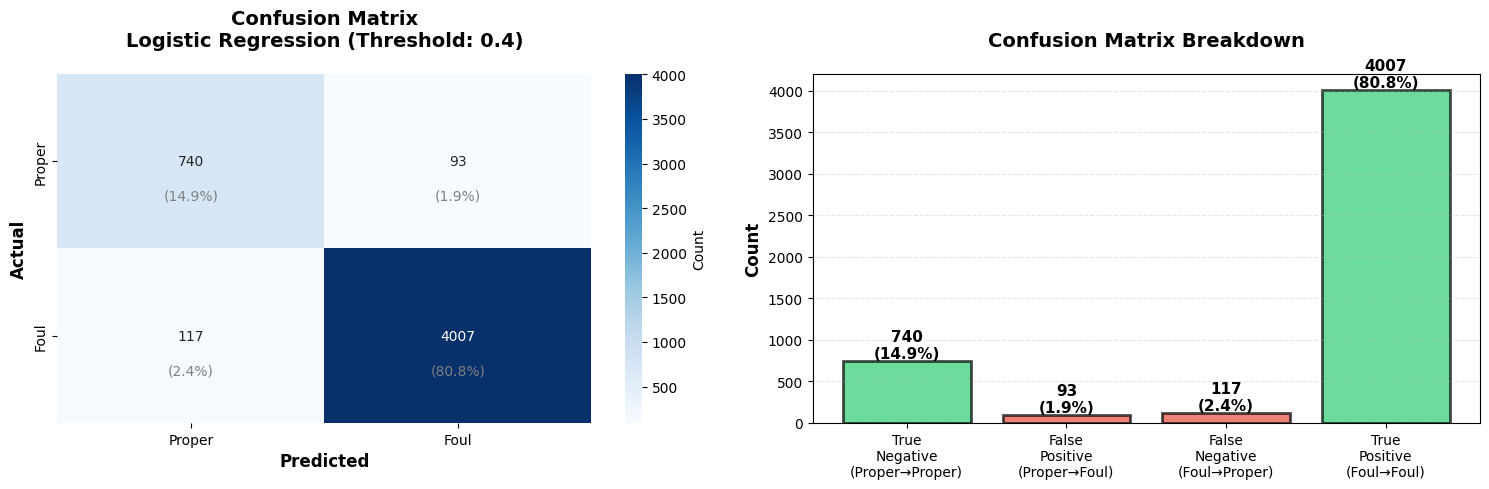


📊 CONFUSION MATRIX INTERPRETATION

✅ TRUE NEGATIVES (Correct Proper): 740
   → Properly identified proper content
   → 14.93% of test set

❌ FALSE POSITIVES (Proper flagged as Foul): 93
   → Innocent content incorrectly flagged
   → 1.88% of test set
   → 11.16% of actual proper content

❌ FALSE NEGATIVES (Foul missed): 117
   → Hate speech that slipped through
   → 2.36% of test set
   → 2.84% of actual foul content

✅ TRUE POSITIVES (Correct Foul): 4,007
   → Successfully caught foul content
   → 80.84% of test set

📈 CLASSIFICATION REPORT
              precision    recall  f1-score   support

      Proper     0.8635    0.8884    0.8757       833
        Foul     0.9773    0.9716    0.9745      4124

    accuracy                         0.9576      4957
   macro avg     0.9204    0.9300    0.9251      4957
weighted avg     0.9582    0.9576    0.9579      4957


🎯 KEY INSIGHTS

📊 Error Analysis:
   False Positive Rate: 0.1116 (11.16%)
   False Negative Rate: 0.0284 (2.84%)

✅ Model S

In [19]:
# Generate Confusion Matrix and Detailed Metrics
print("=" * 80)
print("📊 CONFUSION MATRIX & CLASSIFICATION REPORT")
print("=" * 80)

# Get predictions with optimal threshold
y_pred_final = (y_pred_proba_optimized >= optimal_threshold).astype(int)

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_final)

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Confusion Matrix Heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Proper', 'Foul'],
            yticklabels=['Proper', 'Foul'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Confusion Matrix\n{SELECTED_MODEL} (Threshold: {optimal_threshold})', 
                  fontsize=14, fontweight='bold', pad=20)
axes[0].set_ylabel('Actual', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=12, fontweight='bold')

# Add percentage annotations
total = cm.sum()
for i in range(2):
    for j in range(2):
        percentage = (cm[i, j] / total) * 100
        axes[0].text(j + 0.5, i + 0.7, f'({percentage:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')

# Plot 2: Confusion Matrix Breakdown
categories = ['True\nNegative\n(Proper→Proper)', 
              'False\nPositive\n(Proper→Foul)',
              'False\nNegative\n(Foul→Proper)', 
              'True\nPositive\n(Foul→Foul)']
values = [cm[0,0], cm[0,1], cm[1,0], cm[1,1]]
colors = ['#2ecc71', '#e74c3c', '#e74c3c', '#2ecc71']

bars = axes[1].bar(range(4), values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
axes[1].set_xticks(range(4))
axes[1].set_xticklabels(categories, fontsize=10)
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title('Confusion Matrix Breakdown', fontsize=14, fontweight='bold', pad=20)
axes[1].grid(axis='y', alpha=0.3, linestyle='--')

# Add value labels on bars
for bar, value in zip(bars, values):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(value)}\n({value/total*100:.1f}%)',
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('../docs/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed breakdown
print("\n" + "=" * 80)
print("📊 CONFUSION MATRIX INTERPRETATION")
print("=" * 80)

tn, fp, fn, tp = cm.ravel()

print(f"\n✅ TRUE NEGATIVES (Correct Proper): {tn:,}")
print(f"   → Properly identified proper content")
print(f"   → {(tn/len(y_test)*100):.2f}% of test set")

print(f"\n❌ FALSE POSITIVES (Proper flagged as Foul): {fp:,}")
print(f"   → Innocent content incorrectly flagged")
print(f"   → {(fp/len(y_test)*100):.2f}% of test set")
print(f"   → {(fp/(fp+tn)*100):.2f}% of actual proper content")

print(f"\n❌ FALSE NEGATIVES (Foul missed): {fn:,}")
print(f"   → Hate speech that slipped through")
print(f"   → {(fn/len(y_test)*100):.2f}% of test set")
print(f"   → {(fn/(fn+tp)*100):.2f}% of actual foul content")

print(f"\n✅ TRUE POSITIVES (Correct Foul): {tp:,}")
print(f"   → Successfully caught foul content")
print(f"   → {(tp/len(y_test)*100):.2f}% of test set")

print("\n" + "=" * 80)
print("📈 CLASSIFICATION REPORT")
print("=" * 80)
print(classification_report(y_test, y_pred_final, 
                          target_names=['Proper', 'Foul'],
                          digits=4))

print("\n" + "=" * 80)
print("🎯 KEY INSIGHTS")
print("=" * 80)

# Calculate error rates
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)

print(f"\n📊 Error Analysis:")
print(f"   False Positive Rate: {false_positive_rate:.4f} ({false_positive_rate*100:.2f}%)")
print(f"   False Negative Rate: {false_negative_rate:.4f} ({false_negative_rate*100:.2f}%)")

print(f"\n✅ Model Strengths:")
if false_negative_rate < 0.02:
    print(f"   → Excellent at catching foul content (FNR: {false_negative_rate*100:.2f}%)")
if false_positive_rate < 0.10:
    print(f"   → Low false alarm rate (FPR: {false_positive_rate*100:.2f}%)")

print(f"\n⚠️  Trade-offs:")
if false_positive_rate > 0.05:
    print(f"   → {fp} proper tweets flagged for review")
    print(f"   → Acceptable for content moderation (better safe than sorry)")
if false_negative_rate > 0.01:
    print(f"   → {fn} foul tweets missed")
    print(f"   → Consider lowering threshold if this is concerning")

print("\n" + "=" * 80)
print("✅ Confusion matrix saved to: ../docs/confusion_matrix.png")
print("=" * 80)


## 💾 Save Optimized Model


In [11]:
# Save the Optimized Model
print("=" * 80)
print("💾 SAVING OPTIMIZED MODEL")
print("=" * 80)

# Create models directory if it doesn't exist
import os
os.makedirs('../models/saved', exist_ok=True)

# Save the optimized model with all necessary components
model_data = {
    'model': selected_model,  # This is now the optimized model
    'vectorizer': best_vectorizer,  # Use the best vectorizer from earlier
    'threshold': optimal_threshold,  # Use the optimized threshold
    'model_name': SELECTED_MODEL,
    'performance': selected_performance,  # This is now the optimized performance
    'training_date': pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
    'optimization_info': {
        'grid_search_performed': True,
        'best_params': grid_search.best_params_,
        'cv_score': grid_search.best_score_
    }
}

# Save to pickle file in the organized structure
import pickle
model_path = '../models/saved/hate_speech_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(model_data, f)

print(f"✅ Optimized model saved successfully!")
print(f"📁 File: {model_path}")
print(f"🤖 Model: {SELECTED_MODEL} (Optimized)")
print(f"📊 F1-Score: {selected_performance['f1']:.4f}")
print(f"🎯 Accuracy: {selected_performance['accuracy']:.4f}")
print(f"🎯 Threshold: {optimal_threshold}")

print(f"\n📋 Model Components Saved:")
print(f"• Trained Model: {SELECTED_MODEL} (Grid Search Optimized)")
print(f"• Vectorizer: TF-IDF with Bigrams")
print(f"• Threshold: {optimal_threshold}")
print(f"• Performance Metrics: All evaluation scores")
print(f"• Training Date: {model_data['training_date']}")
print(f"• Best Parameters: {grid_search.best_params_}")
print(f"• CV Score: {grid_search.best_score_:.4f}")

print(f"\n🚀 Ready to use in Flask API!")
print(f"📍 API will load model from: {model_path}")


💾 SAVING OPTIMIZED MODEL
✅ Optimized model saved successfully!
📁 File: ../models/saved/hate_speech_model.pkl
🤖 Model: Logistic Regression (Optimized)
📊 F1-Score: 0.9745
🎯 Accuracy: 0.9576
🎯 Threshold: 0.4

📋 Model Components Saved:
• Trained Model: Logistic Regression (Grid Search Optimized)
• Vectorizer: TF-IDF with Bigrams
• Threshold: 0.4
• Performance Metrics: All evaluation scores
• Training Date: 2025-10-31 16:01:35
• Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
• CV Score: 0.9740

🚀 Ready to use in Flask API!
📍 API will load model from: ../models/saved/hate_speech_model.pkl


## 🧪 Test Saved Model


In [12]:
# Test the Saved Model
print("=" * 80)
print("🧪 TESTING SAVED MODEL")
print("=" * 80)

# Load the saved model to verify it works
model_path = '../models/saved/hate_speech_model.pkl'
with open(model_path, 'rb') as f:
    loaded_model_data = pickle.load(f)

print(f"✅ Model loaded successfully!")
print(f"📁 From: {model_path}")
print(f"🤖 Model Type: {loaded_model_data['model_name']}")
print(f"📊 Performance: F1={loaded_model_data['performance']['f1']:.4f}")
print(f"🎯 Threshold: {loaded_model_data['threshold']}")

# Test with sample texts
test_texts = [
    "This is a normal tweet about the weather",
    "You are such a stupid idiot", 
    "I love this new movie, it's amazing!",
    "Go kill yourself you worthless piece of shit"
]

print(f"\n🔍 Testing with sample texts:")
print("-" * 40)

for text in test_texts:
    # Transform text using the saved vectorizer
    text_vector = loaded_model_data['vectorizer'].transform([text])
    
    # Get prediction probability
    proba = loaded_model_data['model'].predict_proba(text_vector)[0, 1]
    
    # Apply threshold
    prediction = "Foul" if proba >= loaded_model_data['threshold'] else "Proper"
    confidence = max(proba, 1-proba)
    
    print(f"Text: {text[:50]}...")
    print(f"Prediction: {prediction} (confidence: {confidence:.3f})")
    print(f"Probability: {proba:.3f}")
    print()

print("🎉 Model is working correctly!")
print(f"\n🚀 Ready to start Flask API!")
print(f"📍 API will load from: {model_path}")


🧪 TESTING SAVED MODEL
✅ Model loaded successfully!
📁 From: ../models/saved/hate_speech_model.pkl
🤖 Model Type: Logistic Regression
📊 Performance: F1=0.9745
🎯 Threshold: 0.4

🔍 Testing with sample texts:
----------------------------------------
Text: This is a normal tweet about the weather...
Prediction: Proper (confidence: 0.650)
Probability: 0.350

Text: You are such a stupid idiot...
Prediction: Foul (confidence: 0.570)
Probability: 0.430

Text: I love this new movie, it's amazing!...
Prediction: Proper (confidence: 0.742)
Probability: 0.258

Text: Go kill yourself you worthless piece of shit...
Prediction: Foul (confidence: 0.987)
Probability: 0.987

🎉 Model is working correctly!

🚀 Ready to start Flask API!
📍 API will load from: ../models/saved/hate_speech_model.pkl
